<a href="https://colab.research.google.com/github/chrisrichardson/fenics-tutorial/blob/main/spring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear elasticity example

Solves a problem on a 3D printed spring, computing displacement for an applied load.



In [1]:
# Install FEniCSx packages
try:
    import dolfinx
except ImportError:
    !wget -q -nc "https://fem-on-colab.github.io/releases/fenicsx-install-release-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
    import dolfinx


+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICSX_INSTALLED=/usr/local/share/fem-on-colab/fenicsx.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenicsx.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/ec24876d/releases/pybind11-install.sh
+ [[ https://github.com/fem-on-colab/fem-on-colab.github.io/raw/ec24876d/releases/pybind11-install.sh == http* ]]
+ PYBIND11_INSTALL_SCRIPT_DOWNLOAD=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/ec24876d/releases/pybind11-install.sh
+ PYBIND11_INSTALL_SCRIPT_PATH=/tmp/pybind11-install.sh
+ [[ ! -f /tmp/pybind11-install.sh ]]
+ wget https://github.com/fem-on-colab/fem-on-colab.github.io/raw/ec24876d/releases/pybind11-install.sh -O /tmp/pybind11-install.sh
--2025-08-15 10:49:26--  https://github.com/fem-on-colab/fem-on-colab.github.io/raw/ec24876d/release

In [2]:
from mpi4py import MPI
import numpy as np
from scipy.sparse.linalg import spsolve

import pyvista
pyvista.global_theme.jupyter_backend = 'static'
pyvista.global_theme.notebook = True
pyvista.start_xvfb()

from ufl import Identity, sym, grad, tr, dx, TestFunction, TrialFunction, Measure, inner

from dolfinx.io import XDMFFile
from dolfinx.plot import vtk_mesh
from dolfinx.fem import functionspace, dirichletbc, locate_dofs_topological
from dolfinx.fem import form, Constant, Function, assemble_scalar
from dolfinx.fem import assemble_matrix, assemble_vector, apply_lifting


  warnings.warn(



In [3]:
# Download the mesh
!wget -q -nc https://raw.githubusercontent.com/chrisrichardson/fenics-tutorial/refs/heads/main/spring.xdmf
!wget -q -nc https://raw.githubusercontent.com/chrisrichardson/fenics-tutorial/refs/heads/main/spring.h5

In [39]:
# Load mesh into memory
with XDMFFile(MPI.COMM_WORLD, "spring.xdmf", "r") as xdmf:
    mesh = xdmf.read_mesh()
    mesh.topology.create_entities(2)
    facet_tags = xdmf.read_meshtags(mesh, "facet_tags")

# Convert mm to m in mesh geometry
mesh.geometry.x[:] *= 0.001

M = form(Constant(mesh, 1.0) * dx)
vol = assemble_scalar(M)
print(f"Volume is {vol * 1e9:.2f} mm³")

Volume is 1405.03 mm³


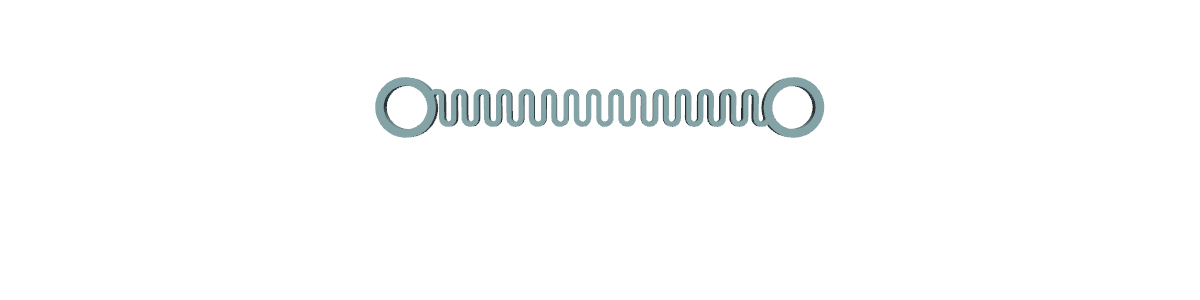

In [56]:
# Visualise the mesh

plotter = pyvista.Plotter(window_size=[1200, 300])
vmesh = vtk_mesh(mesh)
grid = pyvista.UnstructuredGrid(*vmesh);
plotter.add_mesh(grid, show_edges=False)
plotter.camera.position = (0.045, 0.0, 0.2)
plotter.camera.focal_point = (0.045, -0.01, 0.0)
plotter.camera.up = (0.0, 1.0, 0.0)
plotter.camera.zoom(1.5)
plotter.show()

In [57]:
# Elastic parameters
E = 1.8e9 # Young's modulus = 1.8 GPa
ν = 0.35  # Poisson ratio
μ = E / (2.0 * (1.0 + ν))
λ = E * ν / ((1.0 + ν) * (1.0 - 2.0 * ν))

def σ(v):
    """Return an expression for the stress σ given a displacement field v"""
    return 2.0 * μ * sym(grad(v)) + λ * tr(sym(grad(v))) * Identity(len(v))

# Applied traction (external force from weight of bolt)
m_bolt = 6.19e-3 # 6.19g
g = 9.81
r = 5.05e-3
dz = 3.0e-3
t = Constant(mesh, (0.0, -m_bolt * g / (2 * np.pi * r * dz), 0.0))

# Body force (self-weight)
m_spring = 1.58e-3 # 1.58g
rho_spring = m_spring / vol
print(f"Spring density = {rho_spring:.2f} kg/m³")
f = Constant(mesh, (0.0, -rho_spring * g, 0.0))

Spring density = 1124.53 kg/m³


In [58]:
# Define and solve elasticity problem

V = functionspace(mesh, ("Lagrange", 1, (mesh.geometry.dim,)))
mesh.topology.create_connectivity(2, 3)
facets = facet_tags.find(2)
bc = dirichletbc(np.zeros(3),
                 locate_dofs_topological(V, entity_dim=2, entities=facets), V=V)
u, v = TrialFunction(V), TestFunction(V)
ds = Measure("ds", subdomain_data=facet_tags)
a = form(inner(σ(u), grad(v)) * dx)
L = form(inner(f, v) * dx + inner(t, v) * ds(3))

A = assemble_matrix(a, bcs=[bc]).to_scipy().tocsr()
b = assemble_vector(L)
apply_lifting(b.array, [a], bcs=[[bc]])
bc.set(b.array)

uh = Function(V)
uh.x.array[:] = spsolve(A, b.array)


In [59]:
displacement = uh.x.array[:].reshape((-1, 3))
# mesh.geometry.x[:] += displacement



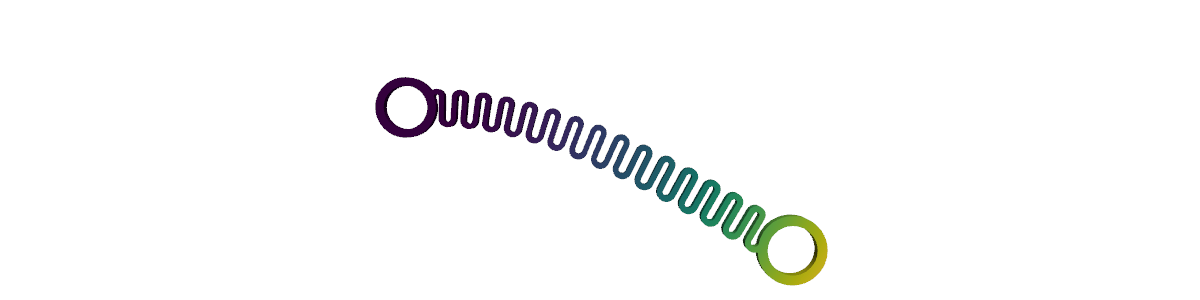

In [61]:
# Replot with displacement
plotter = pyvista.Plotter(window_size=[1200, 300])
grid.point_data["u"] = displacement
grid.set_active_scalars("u")
warped = grid.warp_by_vector()
plotter.add_mesh(warped, show_edges=False)
plotter.camera.position = (0.045, 0.0, 0.2)
plotter.camera.focal_point = (0.045, -0.01, 0.0)
plotter.camera.up = (0.0, 1.0, 0.0)
plotter.camera.zoom(1.5)
plotter.remove_scalar_bar()
plotter.show()

In [46]:
print(f"Max displacement is: {1000.0 * displacement[:, 1].min()} mm")

Max displacement is: -37.56058912482354 mm
